# Test contour algorithms

In [1]:
using Images
using Plots
using Revise
using FileIO
using Statistics: mean

In [2]:
Revise.includet("Contours/Contours.jl");
using .Contours

# Generate images

In [3]:
function plot_circle!(image, color, radius)
    # backward algorithm
    height, width = size(image)
    centre = (width/2, height/2)
    for x in 1:height
        for y in 1: width
            z = radius^2 - (x - centre[1])^2 - (y - centre[2])^2
            if z > 0
                img_circle[CartesianIndex(y, x)] = color
            end
        end
    end
end

plot_circle! (generic function with 1 method)

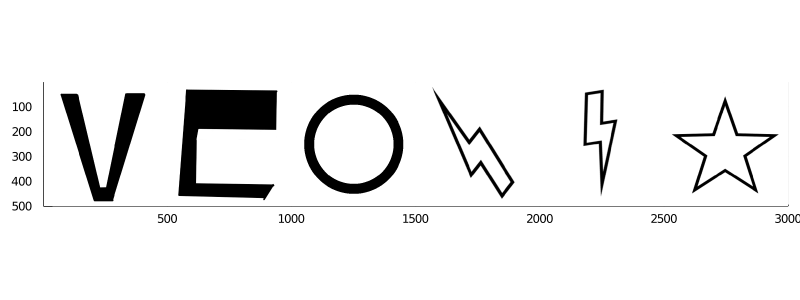

In [4]:
imsize= 500
radius = 200
img_circle = Gray.(ones(imsize, imsize))
plot_circle!(img_circle, 0, radius)
plot_circle!(img_circle, 1, 0.8*radius)
img_circle

img_v = load("images/v_shape.png")
img_e = load("images/e_shape.png")
img_inv_lightning = load("images/inverted_lightning.png")
img_lightning = load("images/lightning.png")
img_star = load("images/star.png")

test_images = [img_v, img_e, img_circle, img_inv_lightning, img_lightning, img_star]
for i in 1:length(test_images)
    image = test_images[i]
    test_images[i] = Gray.(imresize(image, (imsize, imsize)))
end

plot(hcat(test_images...), size=(800, 300))

In [5]:
test_images = test_images[1:3]; # no contours found for the other types

## Contours and Centroids

Contours

In [6]:
function get_max_contour(contours)
    pair_max = ([], -Inf)
    for contour in contours[2:end] # exclude image border
        area = calc_area_contour(contour)
        if area > pair_max[2]
            pair_max = (contour, area)
        end
    end
    return pair_max
end

get_max_contour (generic function with 1 method)

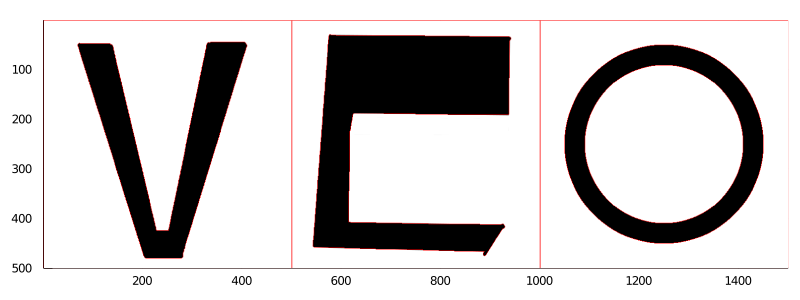

In [7]:
outputs = []
contours_max = []
for image in test_images
    image_contour = RGB.(image)
    gray = Gray.(image)
    contours = find_contours(gray)
    draw_contours!(image_contour, RGB(1, 0, 0), contours)
    push!(outputs, image_contour)
    
    pair_max = get_max_contour(contours)
    push!(contours_max, pair_max[1])
end
frame = plot(hcat(outputs...), size=(800, 300))

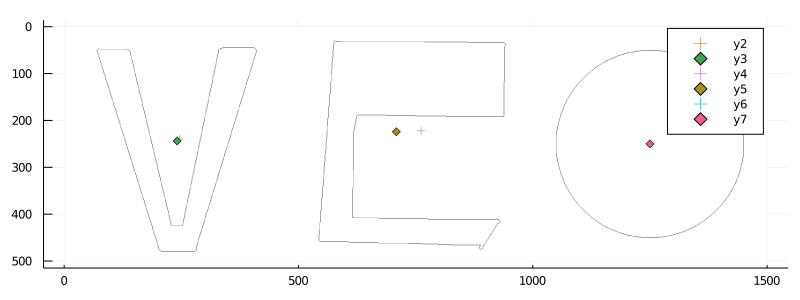

In [8]:
mean_points = []
centroids = []
outputs = []
for contour in contours_max
    if (length(contour) == 0)
        push!(mean_points, nothing)
        push!(centroids, nothing)
        continue
    end
    x = [point[1] for point in contour]
    y = [point[2] for point in contour]
    mean_point = (mean(x), mean(y))
    push!(mean_points, mean_point)
    
    centroid = calc_centroid_contour(contour)
    push!(centroids, centroid)
end

for i in 1:length(test_images)
    T = typeof(test_images[i]).parameters[1]
    image_out = ones(T, size(test_images[i]))
    draw_contour!(image_out, RGB(1, 0, 0), contours_max[i])
    push!(outputs, image_out)
end


x0 = 0
frame = plot(hcat(outputs...), size=(800, 300))
for i in 1:length(test_images)
    if isnothing(mean_points[i])
        continue
    end
    scatter!(frame, [x0 + mean_points[i][1]], [mean_points[i][2]], markershape=:cross)
    scatter!(frame, [x0 + centroids[i][1]], [centroids[i][2]], markershape=:diamond)
    height, width = size(test_images[i])
    x0 += width
end
frame

  0.324510 seconds (763.91 k allocations: 41.096 MiB, 5.45% gc time)
  0.006493 seconds (48.76 k allocations: 4.905 MiB)
  0.052442 seconds (132.39 k allocations: 9.205 MiB)


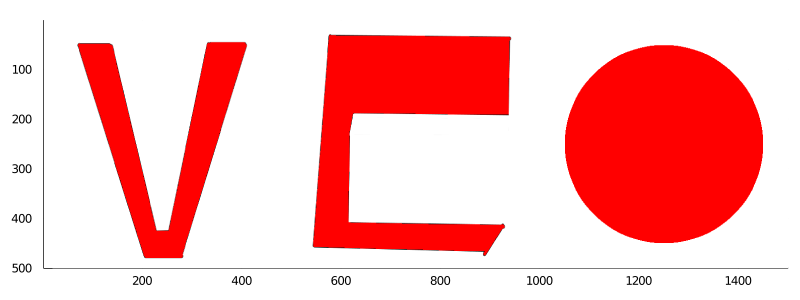

In [9]:
masked_images = []
for i in 1:length(test_images)
    masked = RGB.(test_images[i])
    @time fill_contour!(masked, RGB(1, 0, 0), contours_max[i])
    push!(masked_images, masked)
end
frame = plot(hcat(masked_images...), size=(800, 300))

## Discarded

In [ ]:
imsize= 500
radius = 200
step_size = 0.01
img_circle = Gray.(zeros(imsize, imsize))
centre = (imsize/2, imsize/2, 2)

#forward algorithm
f_top_circle(x, centre, radius) = centre[2] + √(radius^2 - (x - centre[1])^2)
f_bottom_circle(x, centre, radius) = centre[2] - √(radius^2 - (x - centre[1])^2)

top =  [(x, f_top_circle(x, centre, radius)) for x in (centre[1] - radius):step_size:(centre[1] + radius)]
bottom = [(x, f_bottom_circle(x, centre, radius)) for x in (centre[1] - radius):step_size:(centre[1] + radius)]
circle_inds = vcat(top, bottom)

for ind in circle_inds
    x_pix = Int(round(ind[1]))
    y_pix = Int(round(ind[2]))
    img_circle[CartesianIndex(x_pix, y_pix)] = 1
end
img_circle

# there's a hole at the top